# 简要说明

**1.数据集构造: ** 
在读取json数据后，获取itemList中当前时间段10：00商品的销售率和其它特征。然后再获取brandList中之前两个时间段00：00和8：00的商品销售率和其它特征。将来两份数据合并后，我对各个特征两两做乘法和除法这两种非线性方法来构造新特征，(没有采用加减法是因为他们是线性变换，并不能构造有信息量的新特征)，按7：3比例划分训练集和测试集。后续的实验证明了新构造特征的有效性。

**2.评价指标：**  
MSE(均方误差)

**3.机器学习**  
1) 单模型：  
这里我采用了5个算法：Xgboosting(xgb), Random forest(rf), Gradient boosting(gb), Extra tree(et), Supoort vector regressor(svr)训练预测，并用10-fold cross validation调参，展示了训练和测试误差，以及各特征的重要性。

2) Stacking  
我写了一个Ensemble的类，一开始先用xgb, rf, gb, et做2-layer stacking, 最后一层的stacker采用gb, 调参后发现结果并不如单模型的好，分析发现是因为这几个模型的预测结果太相似了，即Pearson相关系数过大, 于是我加入svr的预测结果，计算它们两两间的Pearson相关系数，选出相关系数最小的三个模型做satcking, 结果发现用**XGB, ETR, SVR**做stacking， MSE降低了15%, 从127降到了108。最后用**XGB, ETR, SVR**的stacking对18：00商品销售率做预测并输出'submission.csv',其中'Pred_soldRate'那列为预测值。(注：在excel里'Pred_soldRate'那列显示为空，可能是因为中文编码的问题，但是用pd.read_csv()可以正常获取)

In [1]:
# -*- coding:utf8 -*-
import json
import pandas as pd
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
with open('seckillList_new.json','rb') as data_file:
    data = json.load(data_file)
df = data['seckillInfo']
df['gid']

u'34'

In [3]:
df = data['seckillInfo']
df['newAccount']

In [4]:
brand_pos = pd.DataFrame(df['mBrandPos'])
brand_pos

,10,15,20,25,30,35,40,45,50,55
brandIdOld,7817,8551,9889,14917,7408,6742,189726,21360,10107,17519
brandImg,http://m.360buyimg.com/mobilecms/s620*221_jfs/...,http://m.360buyimg.com/mobilecms/s620*221_jfs/...,http://m.360buyimg.com/mobilecms/s620*221_jfs/...,http://m.360buyimg.com/mobilecms/s620*221_jfs/...,http://m.360buyimg.com/mobilecms/s620*221_jfs/...,http://m.360buyimg.com/mobilecms/s620*221_jfs/...,http://m.360buyimg.com/mobilecms/s620*221_jfs/...,http://m.360buyimg.com/mobilecms/s620*221_jfs/...,http://m.360buyimg.com/mobilecms/s620*221_jfs/...,http://m.360buyimg.com/mobilecms/s620*221_jfs/...
brandName,海尔（Haier）,华硕（ASUS）,君华仕（GENVAS）,润本（RUNBEN）,格兰仕（Galanz）,飞利浦（PHILIPS）,雅萌（YA-MAN）,beats,卡西欧（CASIO）,维达（Vinda）
endTimeRemain,48765,48705,77565,77565,77565,77565,77565,77565,77565,77565
goodsList,"[{u'soldRate': 25, u'startTimeShow': u'00:00',...","[{u'soldRate': 16, u'startTimeShow': u'00:00',...","[{u'soldRate': 24, u'startTimeShow': u'08:00',...","[{u'soldRate': 76, u'startTimeShow': u'08:00',...","[{u'soldRate': 31, u'startTimeShow': u'08:00',...","[{u'soldRate': 30, u'startTimeShow': u'08:00',...","[{u'soldRate': 28, u'startTimeShow': u'08:00',...","[{u'soldRate': 37, u'startTimeShow': u'08:00',...","[{u'soldRate': 31, u'startTimeShow': u'08:00',...","[{u'soldRate': 38, u'startTimeShow': u'08:00',..."
id,6375,6380,6355,6367,6377,6378,6379,6382,6385,6390
position,10,15,20,25,30,35,40,45,50,55
sourceValue,10_7817_2,15_8551_2,20_9889_2,25_14917_2,30_7408_2,35_6742_2,40_189726_2,45_21360_2,50_10107_2,55_17519_2
startTimeRemain,-37634,-37634,-8834,-8834,-8834,-8834,-8834,-8834,-8834,-8834
subTitle,55寸电视2699,爆款直降限时抢购,满199减100,爆款低至9.9元,部分2件8.5折,爆品低至9.9元,iphone红现货抢,乐享千遍 不止一面,换个视角看世界,爆款直降


In [5]:
brand = pd.DataFrame(df['brandList'])
brand

,brandIdOld,brandImg,brandName,endTimeRemain,goodsList,id,position,sourceValue,startTimeRemain,subTitle,titile
0,7817,http://m.360buyimg.com/mobilecms/s620*221_jfs/...,海尔（Haier）,48765,"[{u'soldRate': 25, u'startTimeShow': u'00:00',...",6375,10,10_7817_2,-37634,55寸电视2699,海尔家装季
1,8551,http://m.360buyimg.com/mobilecms/s620*221_jfs/...,华硕（ASUS）,48705,"[{u'soldRate': 16, u'startTimeShow': u'00:00',...",6380,15,15_8551_2,-37634,爆款直降限时抢购,华硕冰点直击
2,9889,http://m.360buyimg.com/mobilecms/s620*221_jfs/...,君华仕（GENVAS）,77565,"[{u'soldRate': 24, u'startTimeShow': u'08:00',...",6355,20,20_9889_2,-8834,满199减100,品质出游包你满意
3,14917,http://m.360buyimg.com/mobilecms/s620*221_jfs/...,润本（RUNBEN）,77565,"[{u'soldRate': 76, u'startTimeShow': u'08:00',...",6367,25,25_14917_2,-8834,爆款低至9.9元,妈妈的安心之选
4,7408,http://m.360buyimg.com/mobilecms/s620*221_jfs/...,格兰仕（Galanz）,77565,"[{u'soldRate': 31, u'startTimeShow': u'08:00',...",6377,30,30_7408_2,-8834,部分2件8.5折,品质厨电疯抢
5,6742,http://m.360buyimg.com/mobilecms/s620*221_jfs/...,飞利浦（PHILIPS）,77565,"[{u'soldRate': 30, u'startTimeShow': u'08:00',...",6378,35,35_6742_2,-8834,爆品低至9.9元,个护健康变形记
6,189726,http://m.360buyimg.com/mobilecms/s620*221_jfs/...,雅萌（YA-MAN）,77565,"[{u'soldRate': 28, u'startTimeShow': u'08:00',...",6379,40,40_189726_2,-8834,iphone红现货抢,从新开始 红遍中国
7,21360,http://m.360buyimg.com/mobilecms/s620*221_jfs/...,beats,77565,"[{u'soldRate': 37, u'startTimeShow': u'08:00',...",6382,45,45_21360_2,-8834,乐享千遍 不止一面,娱乐影音专场
8,10107,http://m.360buyimg.com/mobilecms/s620*221_jfs/...,卡西欧（CASIO）,77565,"[{u'soldRate': 31, u'startTimeShow': u'08:00',...",6385,50,50_10107_2,-8834,换个视角看世界,潮流相机专场
9,17519,http://m.360buyimg.com/mobilecms/s620*221_jfs/...,维达（Vinda）,77565,"[{u'soldRate': 38, u'startTimeShow': u'08:00',...",6390,55,55_17519_2,-8834,爆款直降,清洁品质榜单


In [6]:
haier_goods = pd.DataFrame(brand.iloc[0]['goodsList'])
haier_goods.head()

,biInfo,classifyType,endRemainTime,imageurl,jdPrice,miaoSha,miaoShaPrice,promotionId,seckillNum,soldRate,sourceValue,spuId,startRemainTime,startTimeShow,tagText,tagType,top,wareId,wname
0,2,None,48766,http://m.360buyimg.com/mobilecms/s220x220_jfs/...,1998,True,1299,197428790,1000,25,null_1_1156051_0_2,1015707,-37634,00:00,,0,1,1156051,海尔(Haier)80升D系列数显无线遥控 大容量 一级能效 双管变频加热 专利防电墙电热水...
1,2,None,48766,http://m.360buyimg.com/mobilecms/s220x220_jfs/...,5299,True,4999,197513270,2000,20,null_1_2827318_0_2,2827318,-37634,00:00,,0,1,2827318,【成交价3999】海尔（Haier）BCD-642WDVMU1 642升变频风冷无霜对开门智...
2,2,None,48766,http://m.360buyimg.com/mobilecms/s220x220_jfs/...,9999,True,7999,197481654,200,32,null_1_3517689_0_2,1338399,-37634,00:00,None,0,1,3517689,海尔模卡（MOOKA）U70H3 70英寸 4K安卓智能网络纤薄窄边框UHD高清LED液晶电...


In [7]:
"""
将brandList每个品牌里的goodsList拼接，添加到训练集中
"""
temp_cols = ['jdPrice','miaoShaPrice','soldRate','startRemainTime','endRemainTime','startTimeShow']
temp = None
for i in xrange(len(brand)):
    temp_df = pd.DataFrame(brand.iloc[i]['goodsList'])
    temp = pd.concat([temp,temp_df[temp_cols]],axis=0)
temp.head()

,jdPrice,miaoShaPrice,soldRate,startRemainTime,endRemainTime,startTimeShow
0,1998,1299,25,-37634,48766,00:00
1,5299,4999,20,-37634,48766,00:00
2,9999,7999,32,-37634,48766,00:00
0,4529,3699,16,-37634,48706,00:00
1,6049,4899,31,-37634,48706,00:00


In [8]:
"""
检查有无缺失值
"""
temp.isnull().any()

jdPrice            False
miaoShaPrice       False
soldRate           False
startRemainTime    False
endRemainTime      False
startTimeShow      False
dtype: bool

In [9]:
"""
将所有值转换为数值型,并计算折扣差价discount和折扣率rate
"""
temp[temp_cols[:-1]] = temp[temp_cols[:-1]].apply(pd.to_numeric)
temp['discount'] = temp.jdPrice - temp.miaoShaPrice
temp['rate'] = temp.miaoShaPrice / temp.jdPrice 
temp.head()

,jdPrice,miaoShaPrice,soldRate,startRemainTime,endRemainTime,startTimeShow,discount,rate
0,1998.0,1299.0,25,-37634,48766,00:00,699.0,0.650150
1,5299.0,4999.0,20,-37634,48766,00:00,300.0,0.943386
2,9999.0,7999.0,32,-37634,48766,00:00,2000.0,0.799980
0,4529.0,3699.0,16,-37634,48706,00:00,830.0,0.816737
1,6049.0,4899.0,31,-37634,48706,00:00,1150.0,0.809886


In [10]:
item = pd.DataFrame(df['itemList'])
item.iloc[0]

activeId                                                      232257
adword                                                              
book                                                           false
cName                                                               
canBuy                                                          true
canFreeRead                                                    false
cid                                                                 
clockNum                                                           0
colorRGB                                                     #7A44FB
discount                                                      131.00
endRemainTime                                                  84764
good                                                                
imageurl           http://m.360buyimg.com/mobilecms/s220x220_jfs/...
jdPrice                                                          298
message                           

  startTimeShow   soldRate
0         00:00  24.500000
1         08:00  32.875000
2         10:00  31.396226


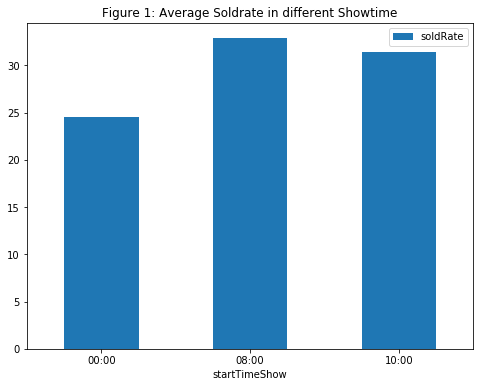

In [11]:
gg = temp[['startTimeShow','soldRate']]
gg = pd.concat([gg,item[['startTimeShow','soldRate']]] ,axis=0)
#gg['startTimeShow'].unique()
grouped_gg = gg.groupby('startTimeShow').mean()
grouped_gg.plot(kind='bar',rot=360,figsize=(8,6),title= 'Figure 1: Average Soldrate in different Showtime')
print grouped_gg.reset_index().head()

由Figure 1可知，深夜0点的平均销售率小于8：00和10：00两个正常时间段，且8：00和10：00差距不大，这点与常识相符.

In [12]:
"""
对itemList中的数据做相同处理
"""
cols = ['discount','jdPrice','miaoShaPrice','soldRate','startRemainTime','endRemainTime','startTimeShow']
train = item[cols]
train[cols[:-1]]= train[cols[:-1]].apply(pd.to_numeric)
train['rate'] = train.miaoShaPrice / train.jdPrice
train.head()

,discount,jdPrice,miaoShaPrice,soldRate,startRemainTime,endRemainTime,startTimeShow,rate
0,131.0,298.0,167.0,26,-1634,84764,10:00,0.560403
1,129.2,299.0,169.8,30,-1634,84764,10:00,0.567893
2,411.0,2599.0,2188.0,31,-1634,84764,10:00,0.841862
3,300.0,2788.0,2488.0,26,-1634,84764,10:00,0.892396
4,49.0,98.0,49.0,34,-1634,84764,10:00,0.500000


In [13]:
"""
将temp和train合并，构造数据集
"""
showtime = {'00:00':0, '08:00':1,'10:00':2}
new_train = pd.concat([temp,train],axis=0)
new_train['startTimeShow'] = new_train.startTimeShow.map(showtime)
len(new_train)

83

In [14]:
new_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83 entries, 0 to 52
Data columns (total 8 columns):
discount           83 non-null float64
endRemainTime      83 non-null int64
jdPrice            83 non-null float64
miaoShaPrice       83 non-null float64
rate               83 non-null float64
soldRate           83 non-null int64
startRemainTime    83 non-null int64
startTimeShow      83 non-null int64
dtypes: float64(4), int64(4)
memory usage: 5.8 KB


In [15]:
new_train.head()

,discount,endRemainTime,jdPrice,miaoShaPrice,rate,soldRate,startRemainTime,startTimeShow
0,699.0,48766,1998.0,1299.0,0.650150,25,-37634,0
1,300.0,48766,5299.0,4999.0,0.943386,20,-37634,0
2,2000.0,48766,9999.0,7999.0,0.799980,32,-37634,0
0,830.0,48706,4529.0,3699.0,0.816737,16,-37634,0
1,1150.0,48706,6049.0,4899.0,0.809886,31,-37634,0


## Feature Engineering

In [16]:
"""
这里我对相邻两列的数据做乘法和除法来用非线性关系构造新特征，加减法这种线性的关系是不必要的，
他们只能分散原特征的feature importance,并不能提高结果。
"""

count = 0
part_cols = ['discount','jdPrice','miaoShaPrice','rate','startRemainTime','endRemainTime']
for id1 in xrange(len(part_cols)-1):
    for id2 in xrange(id1+1, len(part_cols)):
        new_col1 = '{}*{}'.format(part_cols[id1],part_cols[id2])
        new_train[new_col1] = new_train[part_cols[id1]] * new_train[part_cols[id2]]
        new_col2 = '{}/{}'.format(part_cols[id1],part_cols[id2])
        new_train[new_col2] = new_train[part_cols[id1]] / new_train[part_cols[id2]]
        #print new_col1,new_col2
new_train.head()

,discount,endRemainTime,jdPrice,miaoShaPrice,rate,soldRate,startRemainTime,startTimeShow,discount*jdPrice,discount/jdPrice,...,miaoShaPrice*startRemainTime,miaoShaPrice/startRemainTime,miaoShaPrice*endRemainTime,miaoShaPrice/endRemainTime,rate*startRemainTime,rate/startRemainTime,rate*endRemainTime,rate/endRemainTime,startRemainTime*endRemainTime,startRemainTime/endRemainTime
0,699.0,48766,1998.0,1299.0,0.650150,25,-37634,0,1396602.0,0.349850,...,-48886566.0,-0.034517,63347034.0,0.026637,-24467.750751,-0.000017,31705.222222,0.000013,-1835259644,-0.771726
1,300.0,48766,5299.0,4999.0,0.943386,20,-37634,0,1589700.0,0.056614,...,-188132366.0,-0.132832,243781234.0,0.102510,-35503.371580,-0.000025,46005.139460,0.000019,-1835259644,-0.771726
2,2000.0,48766,9999.0,7999.0,0.799980,32,-37634,0,19998000.0,0.200020,...,-301034366.0,-0.212547,390079234.0,0.164028,-30106.447245,-0.000021,39011.824582,0.000016,-1835259644,-0.771726
0,830.0,48706,4529.0,3699.0,0.816737,16,-37634,0,3759070.0,0.183263,...,-139208166.0,-0.098289,180163494.0,0.075945,-30737.064694,-0.000022,39779.972179,0.000017,-1833001604,-0.772677
1,1150.0,48706,6049.0,4899.0,0.809886,31,-37634,0,6956350.0,0.190114,...,-184368966.0,-0.130175,238610694.0,0.100583,-30479.247148,-0.000022,39446.304183,0.000017,-1833001604,-0.772677


In [17]:
new_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83 entries, 0 to 52
Data columns (total 38 columns):
discount                         83 non-null float64
endRemainTime                    83 non-null int64
jdPrice                          83 non-null float64
miaoShaPrice                     83 non-null float64
rate                             83 non-null float64
soldRate                         83 non-null int64
startRemainTime                  83 non-null int64
startTimeShow                    83 non-null int64
discount*jdPrice                 83 non-null float64
discount/jdPrice                 83 non-null float64
discount*miaoShaPrice            83 non-null float64
discount/miaoShaPrice            83 non-null float64
discount*rate                    83 non-null float64
discount/rate                    83 non-null float64
discount*startRemainTime         83 non-null float64
discount/startRemainTime         83 non-null float64
discount*endRemainTime           83 non-null float64
disc

In [18]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import time

from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn import grid_search
from sklearn.metrics import mean_squared_error, make_scorer

C:\Users\KrystalU\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\KrystalU\Anaconda2\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [19]:
"""
配置XGB环境
"""
import os

mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-6.3.0-posix-seh-rt_v5-rev1\\mingw64\\bin'

os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']
from xgboost import XGBRegressor
import xgboost as xgb

In [20]:
"""
对原数据集按7：3划分训练集和测试集
"""
soldRate_index = new_train.columns.tolist().index('soldRate')
X_cols =  new_train.columns.tolist()[:soldRate_index] + new_train.columns.tolist()[soldRate_index+1:]
y_col = ['soldRate']
col_list = new_train.columns.tolist()
X_total= new_train[X_cols]
y_total = new_train[y_col]
X_train, X_test, y_train, y_test = train_test_split(X_total, y_total, test_size=0.3, random_state=2017)

In [21]:
from sklearn import grid_search
def mean_squared_error_(ground_truth, predictions):
    return mean_squared_error(ground_truth, predictions) ** 0.5

RMSE = make_scorer(mean_squared_error_, greater_is_better=False)

# 1.单模型预测

## 1) XGBoosting

In [22]:
"""
GridSearch寻找最佳参数, 这里做的是10-fold cross validation
"""
start_time = time.clock()
clf = xgb.XGBRegressor(seed=2017)
param_grid = {
        'n_estimators': [50,80,100,200],
        'learning_rate': [0.05,0.08,0.1],
        'max_depth': [7, 9, 10],
        'subsample': [0.7, 0.8]
    }

model = GridSearchCV(estimator=clf, param_grid=param_grid,n_jobs=8,cv=10,verbose=20)
model.fit(X_train,y_train)

print('--- Grid Search Completed: %s minutes ---' % round(((time.clock() - start_time) / 60), 2))
print('Param grid:')
print(param_grid)
print('Best Params:')
print(model.best_params_)
print('Best CV Score:')
print(-model.best_score_)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done   3 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done   4 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done   5 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done   6 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done   7 tasks      | elapsed:    3.7s
[Parallel(n_jobs=8)]: Done   8 tasks      | elapsed:    4.3s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    4.3s
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    4.3s
[Parallel(n_jobs=8)]: Done  11 tasks      | elapsed:    4.3s
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:    4.3s
[Parallel(n_jobs=8)]: Done  13 tasks      | elapsed:    4.3s
[Parallel(n_jobs=8)]: Done  14 tasks      | elapsed:    4.3s
[Parallel(n_jobs=8)]: Done  15 tasks      | elapsed:    4.3s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    4.5s
[Parallel(n_jobs=8)]: Do

--- Grid Search Completed: 0.73 minutes ---
Param grid:
{'n_estimators': [50, 80, 100, 200], 'subsample': [0.7, 0.8], 'learning_rate': [0.05, 0.08, 0.1], 'max_depth': [7, 9, 10]}
Best Params:
{'n_estimators': 80, 'subsample': 0.8, 'learning_rate': 0.05, 'max_depth': 9}
Best CV Score:
0.0143665471352


[Parallel(n_jobs=8)]: Done 720 out of 720 | elapsed:   43.5s finished


In [23]:
"""
Best Params:
{'n_estimators': 80, 'subsample': 0.8, 'learning_rate': 0.08, 'max_depth': 9}
Best CV Score:
0.362555032839
"""
xgb_best = XGBRegressor(n_estimators=80,subsample=0.8,learning_rate=0.05,max_depth=9)
xgb_best.fit(X_train,y_train)
xgb_train_pred = xgb_best.predict(X_train)
xgb_test_pred = xgb_best.predict(X_test)
print 'Training mse:{}'.format(mse(y_train,xgb_train_pred))
print 'Test mse:{}'.format(mse(y_test,xgb_test_pred))

Training mse:7.77646465603
Test mse:157.566031983


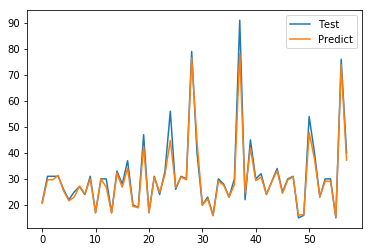

In [24]:
x_train_range = xrange(len(y_train))
plt.plot(x_train_range, y_train, '-',label='Train')
plt.plot(x_train_range, xgb_train_pred, '-',label='Predict')
plt.legend()

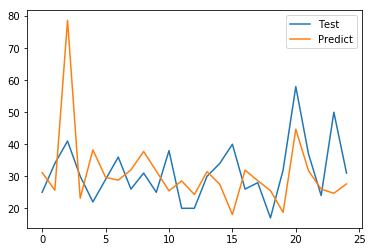

In [25]:
x_test_range = xrange(len(y_test))
plt.plot(x_test_range, y_test, '-',label='Test')
plt.plot(x_test_range, xgb_test_pred, '-',label='Predict')
plt.legend()

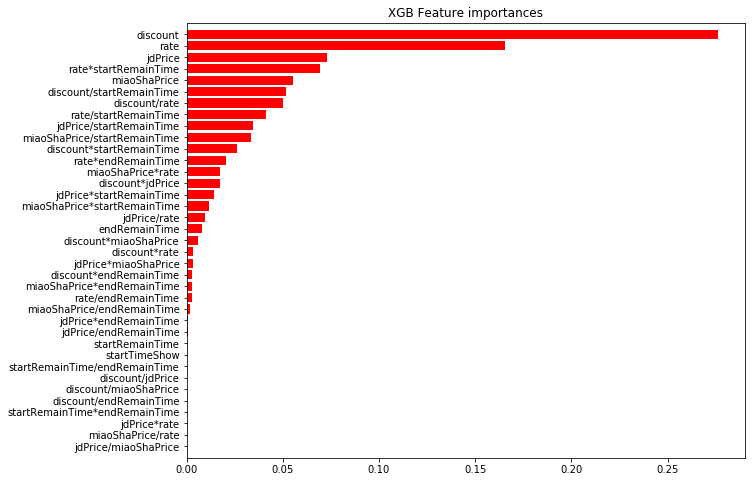

In [26]:
importances = xgb_best.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(10,8))
plt.title("XGB Feature importances")
plt.barh(range(X_train.shape[1]), importances[indices],
           color="r", align="center")

plt.yticks(range(X_train.shape[1]), X_train.columns[indices],rotation='horizontal')
plt.ylim([-1, X_train.shape[1]])
plt.show()

由上图可知，xgb里前6个最重要的feature是*discount, rate, jdPrice, rate $*$ startRemainTime, miaoshaPrice, discount $/$ startRemainTime*, 其中*rate $*$ startRemainTime* 和 *discount $/$ startRemainTime*是新构造的特征。 我也测试过仅使用原来的特征做训练， 但是效果不如加了新构造的feature。 新构造的feature改善了最后的回归结果。

## 2) Random Forest

In [27]:
"""
GridSearch寻找最佳参数, 这里做的是10-fold cross validation
"""
start_time = time.clock()
rf = RandomForestRegressor(n_jobs=4, random_state=2017, verbose=1)

param_grid = {'n_estimators': [50,80,100,200,500]}
model = grid_search.GridSearchCV(estimator=rf, param_grid=param_grid, n_jobs=4, cv=10, verbose=20)
model.fit(X_train, y_train)

print('--- Grid Search Completed: %s minutes ---' % round(((time.clock() - start_time) / 60), 2))
print('Best Params:')
print(model.best_params_)
print('Best CV Score:')
print(-model.best_score_)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    3.8s
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:    3.8s
[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:    4.1s
[Parallel(n_jobs=4)]: Do

--- Grid Search Completed: 0.28 minutes ---
Best Params:
{'n_estimators': 500}
Best CV Score:
0.525751990185


In [28]:
"""
Best Params:
{'n_estimators': 500}
Best CV Score:
0.531218053656
"""
rf_best = RandomForestRegressor(n_estimators=500,random_state=2017)
rf_best.fit(X_train,y_train)
rf_train_pred = rf_best.predict(X_train)
rf_test_pred = rf_best.predict(X_test)
print 'Training mse:{}'.format(mse(y_train,rf_train_pred)) 
print 'Test mse:{}'.format(mse(y_test,rf_test_pred))

Training mse:17.4532802759
Test mse:141.4946664


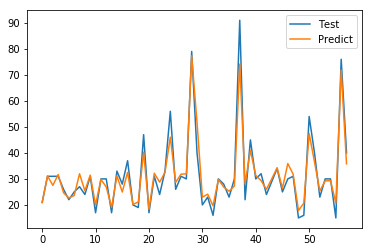

In [29]:
x_train_range = xrange(len(X_train))
plt.plot(x_train_range, y_train, '-',label='Train')
plt.plot(x_train_range, rf_train_pred, '-',label='Predict')
plt.legend()

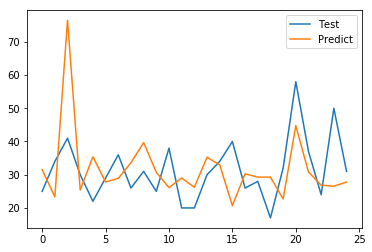

In [30]:
x_test_range = xrange(len(y_test))
plt.plot(x_test_range, y_test, '-',label='Test')
plt.plot(x_test_range, rf_test_pred, '-',label='Predict')
plt.legend()

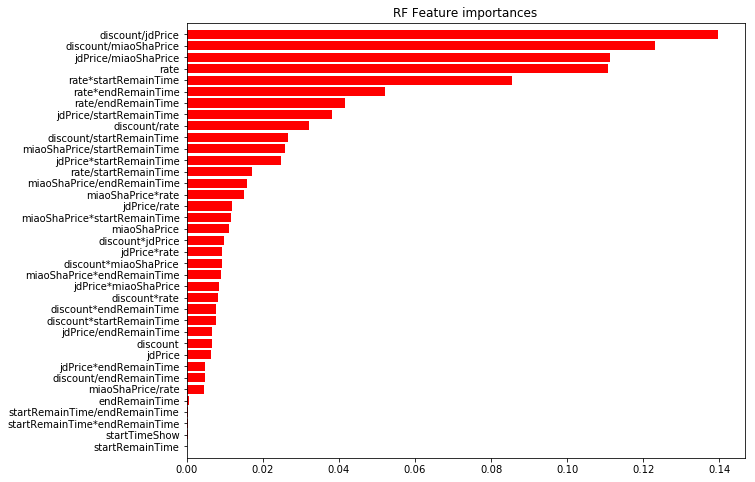

In [31]:
importances = rf_best.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(10,8))
plt.title("RF Feature importances")
plt.barh(range(X_train.shape[1]), importances[indices],
           color="r", align="center")

plt.yticks(range(X_train.shape[1]), X_train.columns[indices],rotation='horizontal')
plt.ylim([-1, X_train.shape[1]])
plt.show()

由上图可知，前6个最重要的特征里有5个是新构造的特征，同时经测试，回归结果mse也比仅用原来的特征好，这说明了新加入特征的有效性。

## 3) Gradient Boosting Regressor

In [32]:
"""
GridSearch寻找最佳参数, 这里做的是10-fold cross validation
"""
start_time = time.clock()
gbr = GradientBoostingRegressor(random_state=2017, verbose=1,criterion='mse')

param_grid = {
    'n_estimators': [20,30,50,60,70,80,90,100,200],
    'learning_rate': [0.05,0.1],
    'subsample': [0.7,0.75,0.8]
}
model = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=10, verbose=20)
model.fit(X_train.values, y_train.values)

print('--- Grid Search Completed: %s minutes ---' % round(((time.clock() - start_time) / 60), 2))
print('Best Params:')
print(model.best_params_)
print('Best CV Score:')
print(-model.best_score_)

Fitting 10 folds for each of 54 candidates, totalling 540 fits
[CV] n_estimators=20, subsample=0.7, learning_rate=0.05 ..............
      Iter       Train Loss      OOB Improve   Remaining Time 
         1         287.9736          -0.7565            0.02s
         2         261.5520           2.2923            0.02s
         3         229.4453          -0.0105            0.02s
         4         216.3591           0.8768            0.02s
         5         136.2679           2.7670            0.01s
         6         102.3316          12.7564            0.01s
         7         174.8256           2.0569            0.01s
         8         150.2438           8.8975            0.01s
         9         162.6161           1.1299            0.01s
        10         114.8951          -0.1415            0.01s
        20          78.6247          -0.7271            0.00s
[CV]  n_estimators=20, subsample=0.7, learning_rate=0.05, score=0.044746, total=   0.0s
[CV] n_estimators=20, subsample=0

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  1

         4         157.8817          -0.1274            0.06s
         5          76.3381           5.4371            0.05s
         6         137.9097          -0.4105            0.04s
         7         125.8014          -0.1604            0.03s
         8         114.1897          -0.5995            0.03s
         9         115.8158          -0.9644            0.03s
        10          85.9593           8.3826            0.02s
        20          51.9370           0.5252            0.00s
[CV]  n_estimators=20, subsample=0.75, learning_rate=0.05, score=0.216623, total=   0.0s
[CV] n_estimators=20, subsample=0.75, learning_rate=0.05 .............
      Iter       Train Loss      OOB Improve   Remaining Time 
         1         209.8049          18.1789            0.02s
         2         197.5415          19.2881            0.02s
         3         215.5563           0.0675            0.02s
         4         187.7647           0.9669            0.02s
         5         122.7889      

[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.2s remaining:    0.0s



[CV]  n_estimators=20, subsample=0.8, learning_rate=0.05, score=0.351278, total=   0.0s
[CV] n_estimators=30, subsample=0.7, learning_rate=0.05 ..............
      Iter       Train Loss      OOB Improve   Remaining Time 
         1         287.9736          -0.7565            0.03s
         2         261.5520           2.2923            0.03s
         3         229.4453          -0.0105            0.02s
         4         216.3591           0.8768            0.02s
         5         136.2679           2.7670            0.02s
         6         102.3316          12.7564            0.02s
         7         174.8256           2.0569            0.02s
         8         150.2438           8.8975            0.01s
         9         162.6161           1.1299            0.01s
        10         114.8951          -0.1415            0.01s
        20          78.6247          -0.7271            0.01s
        30          37.5994           0.2667            0.00s
[CV]  n_estimators=30, subsample=

[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:   19.4s finished


In [33]:
"""
Best Params:
{'n_estimators': 30, 'subsample': 0.7, 'learning_rate': 0.05}
Best CV Score:
0.497504469421
"""
gbr_best = GradientBoostingRegressor(n_estimators=30,subsample = 0.7,learning_rate=0.05)
gbr_best.fit(X_train,y_train)
gbr_train_pred = gbr_best.predict(X_train)
gbr_test_pred = gbr_best.predict(X_test)
print 'Training mse:{}'.format(mse(y_train,gbr_train_pred)) 
print 'Test mse:{}'.format(mse(y_test,gbr_test_pred))

Training mse:46.4867097091
Test mse:118.960753781


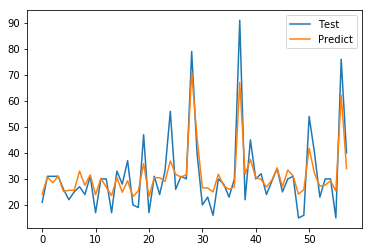

In [34]:
x_train_range = xrange(len(y_train))
plt.plot(x_train_range, y_train, '-',label='Train')
plt.plot(x_train_range, gbr_train_pred, '-',label='Predict')
plt.legend()

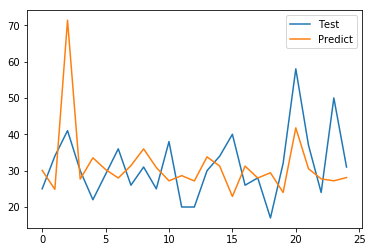

In [35]:
x_test_range = xrange(len(y_test))
plt.plot(x_test_range, y_test, '-',label='Test')
plt.plot(x_test_range, gbr_test_pred, '-',label='Predict')
plt.legend()

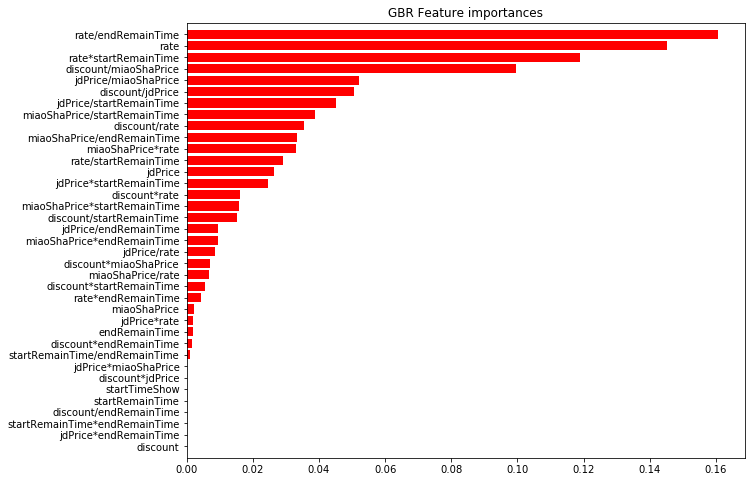

In [36]:
importances = gbr_best.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(10,8))
plt.title("GBR Feature importances")
plt.barh(range(X_train.shape[1]), importances[indices],
           color="r", align="center")

plt.yticks(range(X_train.shape[1]), X_train.columns[indices],rotation='horizontal')
plt.ylim([-1, X_train.shape[1]])
plt.show()

由上图可知，前6个最重要的特征里有5个是新构造的特征，同时经测试，回归结果mse也比仅用原来的特征好，这说明了新加入特征的有效性。

## 4) Extra Tree Regressor

In [37]:
"""
GridSearch寻找最佳参数, 这里做的是10-fold cross validation
"""
start_time = time.clock()
etr = ExtraTreesRegressor(random_state=2017, verbose=1,criterion='mse')

param_grid = {
    'n_estimators': [50,80,100,200,500]
}
model = GridSearchCV(estimator=etr, param_grid=param_grid, cv=10, verbose=20)
model.fit(X_train.values, y_train.values)

print('--- Grid Search Completed: %s minutes ---' % round(((time.clock() - start_time) / 60), 2))
print('Best Params:')
print(model.best_params_)
print('Best CV Score:')
print(-model.best_score_)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] n_estimators=50 .................................................


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ................. n_estimators=50, score=-0.254818, total=   0.2s
[CV] n_estimators=50 .................................................


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV] ................. n_estimators=50, score=-0.606505, total=   0.1s
[CV] n_estimators=50 .................................................


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV] .................. n_estimators=50, score=0.208136, total=   0.1s
[CV] n_estimators=50 .................................................


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV] .................. n_estimators=50, score=0.012319, total=   0.1s
[CV] n_estimators=50 .................................................
[CV] ................. n_estimators=50, score=-0.141086, total=   0.0s
[CV] n_estimators=50 .................................................


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.5s remaining:    0.0s


[CV] ................. n_estimators=50, score=-1.981074, total=   0.1s
[CV] n_estimators=50 .................................................
[CV] .................. n_estimators=50, score=0.012539, total=   0.1s
[CV] n_estimators=50 .................................................


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.7s remaining:    0.0s


[CV] ................. n_estimators=50, score=-5.287142, total=   0.1s
[CV] n_estimators=50 .................................................


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.9s remaining:    0.0s


[CV] .................. n_estimators=50, score=0.427923, total=   0.1s
[CV] n_estimators=50 .................................................


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.1s remaining:    0.0s


[CV] .................. n_estimators=50, score=0.133282, total=   0.1s
[CV] n_estimators=80 .................................................


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    2.4s remaining:    0.0s


[CV] ................. n_estimators=80, score=-0.466950, total=   0.2s
[CV] n_estimators=80 .................................................


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    2.7s remaining:    0.0s


[CV] ................. n_estimators=80, score=-0.441652, total=   0.1s
[CV] n_estimators=80 .................................................


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    3.0s remaining:    0.0s


[CV] .................. n_estimators=80, score=0.143941, total=   0.2s
[CV] n_estimators=80 .................................................


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    3.3s remaining:    0.0s


[CV] ................. n_estimators=80, score=-0.046765, total=   0.1s
[CV] n_estimators=80 .................................................


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    3.6s remaining:    0.0s


[CV] ................. n_estimators=80, score=-0.238260, total=   0.2s
[CV] n_estimators=80 .................................................


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    3.9s remaining:    0.0s


[CV] ................. n_estimators=80, score=-2.145041, total=   0.2s
[CV] n_estimators=80 .................................................


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    4.2s remaining:    0.0s


[CV] .................. n_estimators=80, score=0.014352, total=   0.2s
[CV] n_estimators=80 .................................................


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    4.5s remaining:    0.0s


[CV] ................. n_estimators=80, score=-4.899021, total=   0.2s
[CV] n_estimators=80 .................................................


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    4.8s remaining:    0.0s


[CV] .................. n_estimators=80, score=0.403299, total=   0.1s
[CV] n_estimators=80 .................................................


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    0.0s finished


[CV] .................. n_estimators=80, score=0.121375, total=   0.1s
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV] ................ n_estimators=100, score=-0.533114, total=   0.2s
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV] ................ n_estimators=100, score=-0.558930, total=   0.2s
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV] ................. n_estimators=100, score=0.165111, total=   0.2s
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV] ................ n_estimators=100, score=-0.119437, total=   0.2s
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV] ................ n_estimators=100, score=-0.212171, total=   0.2s
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV] ................ n_estimators=100, score=-2.272169, total=   0.2s
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV] ................. n_estimators=100, score=0.020337, total=   0.2s
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV] ................ n_estimators=100, score=-4.501438, total=   0.2s
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV] ................. n_estimators=100, score=0.390817, total=   0.2s
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV] ................. n_estimators=100, score=0.107919, total=   0.2s
[CV] n_estimators=200 ................................................


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


[CV] ................ n_estimators=200, score=-0.402144, total=   0.5s
[CV] n_estimators=200 ................................................


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


[CV] ................ n_estimators=200, score=-0.825350, total=   0.5s
[CV] n_estimators=200 ................................................


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


[CV] ................. n_estimators=200, score=0.191150, total=   0.5s
[CV] n_estimators=200 ................................................


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


[CV] ................ n_estimators=200, score=-0.062758, total=   0.6s
[CV] n_estimators=200 ................................................


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


[CV] ................ n_estimators=200, score=-0.185098, total=   0.6s
[CV] n_estimators=200 ................................................


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


[CV] ................ n_estimators=200, score=-2.379383, total=   0.6s
[CV] n_estimators=200 ................................................


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


[CV] ................. n_estimators=200, score=0.051373, total=   0.5s
[CV] n_estimators=200 ................................................


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


[CV] ................ n_estimators=200, score=-5.524102, total=   0.6s
[CV] n_estimators=200 ................................................


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


[CV] ................. n_estimators=200, score=0.391236, total=   0.5s
[CV] n_estimators=200 ................................................


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


[CV] ................. n_estimators=200, score=0.075833, total=   0.5s
[CV] n_estimators=500 ................................................


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV] ................ n_estimators=500, score=-0.401524, total=   1.4s
[CV] n_estimators=500 ................................................


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV] ................ n_estimators=500, score=-0.798265, total=   1.4s
[CV] n_estimators=500 ................................................


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV] ................. n_estimators=500, score=0.138532, total=   1.5s
[CV] n_estimators=500 ................................................


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV] ................ n_estimators=500, score=-0.053981, total=   1.6s
[CV] n_estimators=500 ................................................


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV] ................ n_estimators=500, score=-0.198042, total=   1.5s
[CV] n_estimators=500 ................................................


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV] ................ n_estimators=500, score=-2.358779, total=   1.5s
[CV] n_estimators=500 ................................................


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV] ................. n_estimators=500, score=0.062104, total=   1.4s
[CV] n_estimators=500 ................................................


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV] ................ n_estimators=500, score=-5.733734, total=   1.3s
[CV] n_estimators=500 ................................................


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV] ................. n_estimators=500, score=0.372853, total=   1.5s
[CV] n_estimators=500 ................................................


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV] ................. n_estimators=500, score=0.100925, total=   1.6s
--- Grid Search Completed: 0.59 minutes ---
Best Params:
{'n_estimators': 50}
Best CV Score:
0.783099205186


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   35.0s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


In [38]:
etr_best = ExtraTreesRegressor(n_estimators=50)
etr_best.fit(X_train,y_train)
etr_train_pred = etr_best.predict(X_train)
etr_test_pred = etr_best.predict(X_test)
print 'Training mse:{}'.format(mse(y_train,etr_train_pred)) 
print 'Test mse:{}'.format(mse(y_test,etr_test_pred))

Training mse:0.0
Test mse:153.794144


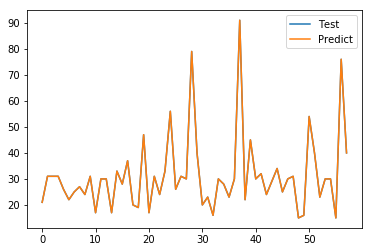

In [39]:
x_train_range = xrange(len(y_train))
plt.plot(x_train_range, y_train, '-',label='Train')
plt.plot(x_train_range, etr_train_pred, '-',label='Predict')
plt.legend()

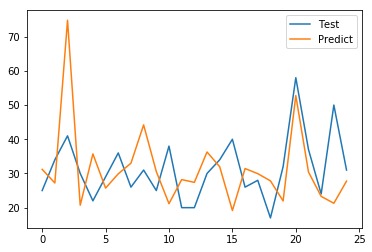

In [40]:
x_test_range = xrange(len(y_test))
plt.plot(x_test_range, y_test, '-',label='Test')
plt.plot(x_test_range, etr_test_pred, '-',label='Predict')
plt.legend()

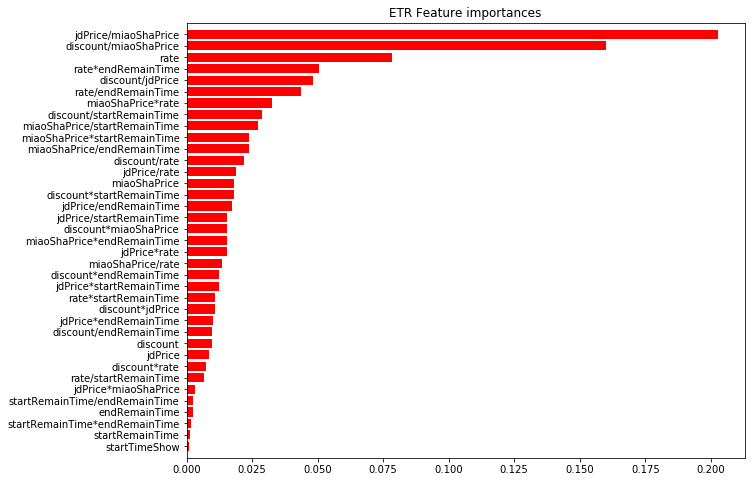

In [41]:
importances = etr_best.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(10,8))
plt.title("ETR Feature importances")
plt.barh(range(X_train.shape[1]), importances[indices],
           color="r", align="center")

plt.yticks(range(X_train.shape[1]), X_train.columns[indices],rotation='horizontal')
plt.ylim([-1, X_train.shape[1]])
plt.show()

## 5) SVR

In [42]:
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import Normalizer

start_time = time.clock()
minmax = MinMaxScaler().fit(X_train)
svr_X_train = minmax.transform(X_train)
svr_X_test = minmax.transform(X_test)
svr = SVR()

param_grid = {
    'C': [0.1,1,10],
    'kernel': ['rbf','poly','linear'],
}
model = GridSearchCV(estimator=svr, param_grid=param_grid, cv=10, verbose=20)
model.fit(svr_X_train, y_train)

print('--- Grid Search Completed: %s minutes ---' % round(((time.clock() - start_time) / 60), 2))
print('Best Params:')
print(model.best_params_)
print('Best CV Score:')
print(-model.best_score_)

Fitting 10 folds for each of 9 candidates, totalling 90 fits
[CV] kernel=rbf, C=0.1 ...............................................
[CV] ............... kernel=rbf, C=0.1, score=-0.453629, total=   0.0s
[CV] kernel=rbf, C=0.1 ...............................................
[CV] ............... kernel=rbf, C=0.1, score=-0.845435, total=   0.0s
[CV] kernel=rbf, C=0.1 ...............................................
[CV] ............... kernel=rbf, C=0.1, score=-0.118823, total=   0.0s
[CV] kernel=rbf, C=0.1 ...............................................
[CV] ............... kernel=rbf, C=0.1, score=-0.016377, total=   0.0s
[CV] kernel=rbf, C=0.1 ...............................................
[CV] ............... kernel=rbf, C=0.1, score=-0.581256, total=   0.0s
[CV] kernel=rbf, C=0.1 ...............................................
[CV] ............... kernel=rbf, C=0.1, score=-2.025472, total=   0.0s
[CV] kernel=rbf, C=0.1 ...............................................
[CV] ...........

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  1

[CV] kernel=linear, C=1 ..............................................
[CV] ............... kernel=linear, C=1, score=0.040630, total=   0.0s
[CV] kernel=linear, C=1 ..............................................
[CV] .............. kernel=linear, C=1, score=-0.021050, total=   0.0s
[CV] kernel=rbf, C=10 ................................................
[CV] ................ kernel=rbf, C=10, score=-0.648115, total=   0.0s
[CV] kernel=rbf, C=10 ................................................
[CV] ................ kernel=rbf, C=10, score=-0.728190, total=   0.0s
[CV] kernel=rbf, C=10 ................................................
[CV] ................ kernel=rbf, C=10, score=-0.184615, total=   0.0s
[CV] kernel=rbf, C=10 ................................................
[CV] ................. kernel=rbf, C=10, score=0.127611, total=   0.0s
[CV] kernel=rbf, C=10 ................................................
[CV] ................ kernel=rbf, C=10, score=-0.453913, total=   0.0s
[CV] k

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.3s finished


In [43]:
svr_best = SVR(kernel='linear',C=1)
svr_best.fit(svr_X_train,y_train)
svr_train_pred = svr_best.predict(svr_X_train)
svr_test_pred = svr_best.predict(svr_X_test)
print "Training mse: {}".format(mse(y_train,svr_train_pred)) 
print "Testing mse: {}".format(mse(y_test,svr_test_pred))

Training mse: 177.833837162
Testing mse: 77.5193453535


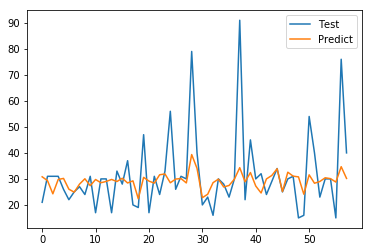

In [44]:
x_train_range = xrange(len(y_train))
plt.plot(x_train_range, y_train, '-',label='Train')
plt.plot(x_train_range, svr_train_pred, '-',label='Predict')
plt.legend()

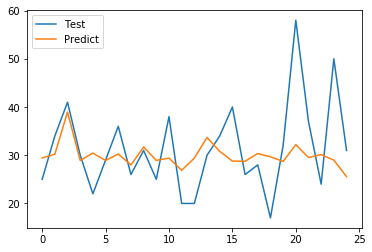

In [45]:
x_test_range = xrange(len(y_test))
plt.plot(x_test_range, y_test, '-',label='Test')
plt.plot(x_test_range, svr_test_pred, '-',label='Predict')
plt.legend()

# 2. 2-layer Stacking

In [46]:
"""
Stacking,因为后面可以看到，各个base model的学习性能相差不大，所以这里我用了简单平均法来做最后的stacking.
"""
class Ensemble(object):
    def __init__(self, n_folds, stacker, base_models, norm=False):
        self.n_folds = n_folds
        self.stacker = stacker
        self.base_models = base_models
        self.norm = norm
        
    def fit_predict(self, X, y, T):
        if not self.norm:
            X = np.array(X)
            T = np.array(T)
        else:
            temp_minmax = MinMaxScaler().fit(X)
            X = temp_minmax.transform(X)
            T = temp_minmax.transform(T)
        y = np.array(y)
       

        folds = list(KFold(len(y), n_folds=self.n_folds, shuffle=True, random_state=2016))

        S_train = np.zeros((X.shape[0], len(self.base_models)))
        S_test = np.zeros((T.shape[0], len(self.base_models)))

        for i, clf in enumerate(self.base_models):

            print('Fitting For Base Model #{0} / {1} ---'.format(i+1, len(self.base_models)))

            S_test_i = np.zeros((T.shape[0], len(folds)))

            for j, (train_idx, test_idx) in enumerate(folds):

                print('--- Fitting For Fold #{0} / {1} ---'.format(j+1, self.n_folds))

                X_train = X[train_idx]
                y_train = y[train_idx]
                X_holdout = X[test_idx]
                # y_holdout = y[test_idx]
                
                clf.fit(X_train, y_train)

                print 'Classifier:{}'.format(clf)
                y_pred = clf.predict(X_holdout)[:]
                S_train[test_idx, i] = y_pred
                S_test_i[:, j] = clf.predict(T)[:]

                print('Elapsed: %s minutes ---' % round(((time.clock() - start_time) / 60), 2))

            S_test[:, i] = S_test_i.mean(1)

            print('Elapsed: %s minutes ---' % round(((time.clock() - start_time) / 60), 2))

        print('--- Base Models Trained: %s minutes ---' % round(((time.clock() - start_time) / 60), 2))

        param_grid = {
             'n_estimators': [50,80,90,100,150,200],
             'learning_rate': [0.1, 0.05, 0.2],
             'subsample': [0.72, 0.75, 0.78]
         }
        
        grid = grid_search.GridSearchCV(estimator=self.stacker, 
                                        param_grid=param_grid, n_jobs=3, cv=10, verbose=20, 
                                        scoring='neg_mean_squared_error')
        grid.fit(S_train, y)

        # a little memo
        message = 'to determine local CV score of #28'

        try:
            print('Param grid:')
            print(param_grid)
            print('Best Params:')
            print(grid.best_params_)
            print('Best CV Score:')
            print(-grid.best_score_)
            print('Best estimator:')
            print(grid.best_estimator_)
            print(message)
        except:
            pass

        print('--- Stacker Trained: %s minutes ---' % round(((time.time() - start_time) / 60), 2))

        y_pred = grid.predict(S_test)[:]

        return y_pred

## 实验结果：

### 1.取4个base model:[RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, XGBRegressor]做Stacking

In [47]:
"""
Base model有RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, XGBRegressor,
每个base model使用调参后的最佳参数, stacker采用GradientBoostingRegressor.
"""
base_models = [
        ExtraTreesRegressor(
            n_jobs=1, random_state=2017, verbose=1,
            n_estimators=50,
        ),
        GradientBoostingRegressor(
            n_estimators=30,subsample = 0.7,learning_rate=0.05,random_state=2017
        ),
        XGBRegressor(
            seed=2017,
            n_estimators=80,subsample=0.8,learning_rate=0.05,max_depth=9
        ),
        RandomForestRegressor(
            n_estimators=500,random_state=2017
        )
    ]

In [48]:
ensemble = Ensemble(
        n_folds=5,
        stacker=GradientBoostingRegressor(
            random_state=2017, verbose=1
        ),
        base_models=base_models
    )

In [49]:
stack_pred = ensemble.fit_predict(X=X_train,y=y_train,T=X_test)

Fitting For Base Model #1 / 4 ---
--- Fitting For Fold #1 / 5 ---
Classifier:ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=50, n_jobs=1, oob_score=False, random_state=2017,
          verbose=1, warm_start=False)
Elapsed: 0.02 minutes ---
--- Fitting For Fold #2 / 5 ---


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


Classifier:ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=50, n_jobs=1, oob_score=False, random_state=2017,
          verbose=1, warm_start=False)
Elapsed: 0.02 minutes ---
--- Fitting For Fold #3 / 5 ---


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


Classifier:ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=50, n_jobs=1, oob_score=False, random_state=2017,
          verbose=1, warm_start=False)
Elapsed: 0.03 minutes ---
--- Fitting For Fold #4 / 5 ---
Classifier:ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=50, n_jobs=1, oob_score=False, random_state=2017,
          verbose=1, warm_start=False)


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


Elapsed: 0.03 minutes ---
--- Fitting For Fold #5 / 5 ---
Classifier:ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=50, n_jobs=1, oob_score=False, random_state=2017,
          verbose=1, warm_start=False)


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


Elapsed: 0.03 minutes ---
Elapsed: 0.03 minutes ---
Fitting For Base Model #2 / 4 ---
--- Fitting For Fold #1 / 5 ---
Classifier:GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=30, presort='auto',
             random_state=2017, subsample=0.7, verbose=0, warm_start=False)
Elapsed: 0.03 minutes ---
--- Fitting For Fold #2 / 5 ---
Classifier:GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=30, presort='auto',
             random_state=2017, subsample=0.7,

[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done   3 tasks      | elapsed:    1.2s
[Parallel(n_jobs=3)]: Done   4 tasks      | elapsed:    1.4s
[Parallel(n_jobs=3)]: Done   5 tasks      | elapsed:    1.5s
[Parallel(n_jobs=3)]: Done   6 tasks      | elapsed:    1.6s
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:    1.8s
[Parallel(n_jobs=3)]: Done   8 tasks      | elapsed:    2.0s
[Parallel(n_jobs=3)]: Done   9 tasks      | elapsed:    2.1s
[Parallel(n_jobs=3)]: Done  10 tasks      | elapsed:    2.3s
[Parallel(n_jobs=3)]: Done  11 tasks      | elapsed:    2.5s
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:    2.6s
[Parallel(n_jobs=3)]: Done  13 tasks      | elapsed:    2.8s
[Parallel(n_jobs=3)]: Done  14 tasks      | elapsed:    3.0s
[Parallel(n_jobs=3)]: Done  15 tasks      | elapsed:    3.1s
[Parallel(n_jobs=3)]: Done  16 tasks      | elapsed:    3.2s
[Parallel(n_jobs=3)]: Do

      Iter       Train Loss      OOB Improve   Remaining Time 
         1         178.9497           5.2328            0.00s
         2         153.5300          28.2191            0.00s
         3         157.6947          -2.6442            0.00s
         4         140.9010          -0.1426            0.00s
         5         116.4762          -0.6246            0.00s
         6          97.8805           9.8872            0.00s
         7          96.6559          -2.2164            0.00s
         8          64.8975           4.8892            0.00s
         9          58.1083           0.1968            0.00s
        10          51.9422           2.0890            0.00s
        20          33.6659          -1.2512            0.02s
        30          21.3656          -0.9216            0.01s
        40          16.0313          -0.6377            0.00s
        50          10.2861          -0.7818            0.00s
Param grid:
{'n_estimators': [50, 80, 90, 100, 150, 200], 'subsample'

[Parallel(n_jobs=3)]: Done 540 out of 540 | elapsed:  1.7min finished


In [50]:
print mse(y_test,stack_pred)

127.950453814


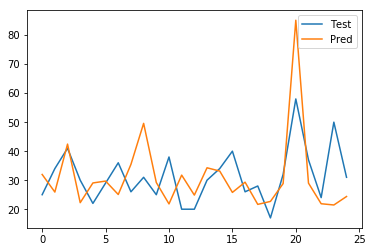

In [51]:
x_test_range = xrange(len(y_test))
plt.plot(x_test_range, y_test, '-',label = 'Test')
plt.plot(x_test_range, stack_pred, '-',label='Pred')
plt.legend()

In [52]:
"""
MSE比较
"""
res = pd.DataFrame({'xgb':[157.566031983], 'rf':[141.4946664], 
                    'gbr':[106.822489988], 'stacking':[127.950453814],'etr':[165.035616]})
res.head()

,etr,gbr,rf,stacking,xgb
0,165.035616,106.82249,141.494666,150.501649,157.566032


In [53]:
"""
xgb, rf, gbr和etr预测结果的Pearson相关系数
"""
import scipy as sp
test_pred = [xgb_test_pred,rf_test_pred,gbr_test_pred,etr_test_pred,svr_test_pred]
names = ['xgb_test_pred','rf_test_pred','gbr_test_pred','etr_test_pred','svr_test_pred']

for i in xrange(len(test_pred)-1):
    for j in xrange(i+1,len(test_pred)):
        print '{} & {} corr: {}'.format(names[i],names[j],sp.stats.pearsonr(test_pred[i],test_pred[j]))

xgb_test_pred & rf_test_pred corr: (0.98375166626436683, 1.1703082546184178e-18)
xgb_test_pred & gbr_test_pred corr: (0.98270593905203796, 2.3856377173661601e-18)
xgb_test_pred & etr_test_pred corr: (0.95975715124540484, 3.523432652822512e-14)
xgb_test_pred & svr_test_pred corr: (0.7942773907837527, 2.1339737130562782e-06)
rf_test_pred & gbr_test_pred corr: (0.99271990896177398, 1.1953090992882995e-22)
rf_test_pred & etr_test_pred corr: (0.96981577399118557, 1.3550050312761772e-15)
rf_test_pred & svr_test_pred corr: (0.83237444132033445, 2.4728823142044077e-07)
gbr_test_pred & etr_test_pred corr: (0.94918614126215972, 4.8890313685199533e-13)
gbr_test_pred & svr_test_pred corr: (0.83168400231429718, 2.5832848723135855e-07)
etr_test_pred & svr_test_pred corr: (0.81289693072582048, 7.9069786512880522e-07)


**结果分析及改进：**
上面的结果计算了xgb, rf, gbr,etr, svr预测结果的Pearson相关系数，可见xgb, rf, gbr,etr,这几个模型预测结果实在是太相像了，这也导致了Stacking的mse比单模型的要差。然后我选了相关系数最小的三个模型**XGB, ETR, SVR**重新做一遍stacking以改进.

### 2.XGB, ETR, SVR Stacking

In [54]:
new_base_models2 = [
        ExtraTreesRegressor(
            n_jobs=1, random_state=2017, verbose=1,
            n_estimators=50,
        ),
        SVR(kernel='linear',C=1),
        XGBRegressor(
            seed=2017,
            n_estimators=80,subsample=0.8,learning_rate=0.05,max_depth=9
        )
    ]

In [55]:
new_ensemble2 = Ensemble(
        n_folds=5,
        stacker=GradientBoostingRegressor(
            random_state=2017, verbose=1
        ),
        base_models=new_base_models2,
        norm = True
    )
new_stack_pred2 = new_ensemble2.fit_predict(X=X_train,y=y_train,T=X_test)

Fitting For Base Model #1 / 3 ---
--- Fitting For Fold #1 / 5 ---
Classifier:ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=50, n_jobs=1, oob_score=False, random_state=2017,
          verbose=1, warm_start=False)
Elapsed: 1.94 minutes ---
--- Fitting For Fold #2 / 5 ---


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


Classifier:ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=50, n_jobs=1, oob_score=False, random_state=2017,
          verbose=1, warm_start=False)
Elapsed: 1.94 minutes ---
--- Fitting For Fold #3 / 5 ---


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


Classifier:ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=50, n_jobs=1, oob_score=False, random_state=2017,
          verbose=1, warm_start=False)
Elapsed: 1.95 minutes ---
--- Fitting For Fold #4 / 5 ---
Classifier:ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=50, n_jobs=1, oob_score=False, random_state=2017,
          verbose=1, warm_start=False)


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


Elapsed: 1.95 minutes ---
--- Fitting For Fold #5 / 5 ---
Classifier:ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=50, n_jobs=1, oob_score=False, random_state=2017,
          verbose=1, warm_start=False)
Elapsed: 1.95 minutes ---
Elapsed: 1.95 minutes ---
Fitting For Base Model #2 / 3 ---
--- Fitting For Fold #1 / 5 ---
Classifier:SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
Elapsed: 1.95 minutes ---
--- Fitting For Fold #2 / 5 ---
Classifier:SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
Elapsed: 1.95 minutes ---
--- Fitting For Fold #3 / 5 ---
Classifier:SVR(C=1, cache_size

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


Classifier:XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.05, max_delta_step=0, max_depth=9,
       min_child_weight=1, missing=None, n_estimators=80, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=2017, silent=True, subsample=0.8)
Elapsed: 1.95 minutes ---
--- Fitting For Fold #2 / 5 ---
Classifier:XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.05, max_delta_step=0, max_depth=9,
       min_child_weight=1, missing=None, n_estimators=80, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=2017, silent=True, subsample=0.8)
Elapsed: 1.96 minutes ---
--- Fitting For Fold #3 / 5 ---
Classifier:XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.05, max_delta_step=0, max_depth=9,
       min_child_weight=1, missing=None, n_estimator

[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done   3 tasks      | elapsed:    1.2s
[Parallel(n_jobs=3)]: Done   4 tasks      | elapsed:    1.3s
[Parallel(n_jobs=3)]: Done   5 tasks      | elapsed:    1.6s
[Parallel(n_jobs=3)]: Done   6 tasks      | elapsed:    1.7s
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:    1.8s
[Parallel(n_jobs=3)]: Done   8 tasks      | elapsed:    2.1s
[Parallel(n_jobs=3)]: Done   9 tasks      | elapsed:    2.2s
[Parallel(n_jobs=3)]: Done  10 tasks      | elapsed:    2.2s
[Parallel(n_jobs=3)]: Done  11 tasks      | elapsed:    2.6s
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:    2.7s
[Parallel(n_jobs=3)]: Done  13 tasks      | elapsed:    2.8s
[Parallel(n_jobs=3)]: Done  14 tasks      | elapsed:    3.0s
[Parallel(n_jobs=3)]: Done  15 tasks      | elapsed:    3.2s
[Parallel(n_jobs=3)]: Done  16 tasks      | elapsed:    3.2s
[Parallel(n_jobs=3)]: Do

      Iter       Train Loss      OOB Improve   Remaining Time 
         1         198.1388           4.8703            0.00s
         2         180.6222          16.1606            0.00s
         3         201.9604          -0.0236            0.00s
         4         190.0097           0.5183            0.00s
         5         168.3732          -0.0277            0.00s
         6         144.6892           8.8127            0.00s
         7         156.8560           0.3399            0.00s
         8         101.5647           9.1507            0.00s
         9         102.3345           7.4359            0.00s
        10          79.6244           0.5638            0.00s
        20          68.7809           0.3703            0.00s
        30          51.2067          -0.1702            0.00s
        40          41.6618          -0.3765            0.00s
        50          30.2718           0.1906            0.00s
Param grid:
{'n_estimators': [50, 80, 90, 100, 150, 200], 'subsample'

[Parallel(n_jobs=3)]: Done 540 out of 540 | elapsed:  1.7min finished


In [56]:
print 'Test Error:{}'.format(mse(y_test,new_stack_pred2))

Test Error:108.584511465


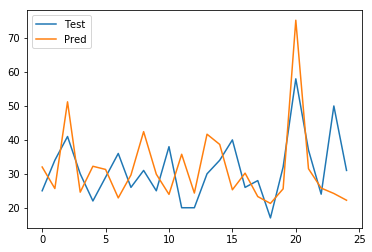

In [57]:
x_test_range = xrange(len(y_test))
plt.plot(x_test_range, y_test, '-',label = 'Test')
plt.plot(x_test_range, new_stack_pred2, '-',label='Pred')
plt.legend()

**结果分析**：这次用**XGB, ETR, SVR**做stacking， MSE降低了15%, 从127降到了108, 且好于所有树模型，虽然高于SVR,但是从SVR的预测销售率和实际销售率看,SVR的预测结果相当平滑，对实际销售率的指导意义不大。  
**结论**：1.做Stacking时，各base model的预测结果相关系数需要尽量低。2.最后决定采用**XGB, ETR, SVR**的stacking对gid = 42, 18：00场次的销售率做预测。

## 对要预测数据做与测试集相同的处理，用XGB, ETR, SVR的stacking预测，并将结果输出为'submission.csv'.

In [58]:
with open('seckillListGid42.json','rb') as data_file:
    data1 = json.load(data_file)
df1 = data1['seckillInfo']
df1['gid']

u'42'

In [59]:
test_data = pd.DataFrame(df1['itemList'])[part_cols]
test_data.drop('rate',axis=1,inplace=True)
test_data = test_data.apply(pd.to_numeric)
test_data['rate'] = test_data['miaoShaPrice'] / test_data['jdPrice']
test_data.head()

,discount,jdPrice,miaoShaPrice,startRemainTime,endRemainTime,rate
0,40.0,119.0,79.0,26459,112858,0.663866
1,29.1,69.0,39.9,26459,112858,0.578261
2,20.0,89.0,69.0,26459,112858,0.775281
3,91.2,120.0,28.8,26459,112858,0.240000
4,128.2,158.0,29.8,26459,112858,0.188608


In [60]:
part_cols = ['discount','jdPrice','miaoShaPrice','rate','startRemainTime','endRemainTime']
for id1 in xrange(len(part_cols)-1):
    for id2 in xrange(id1+1, len(part_cols)):
        new_col1 = '{}*{}'.format(part_cols[id1],part_cols[id2])
        test_data[new_col1] = test_data[part_cols[id1]] * test_data[part_cols[id2]]
        new_col2 = '{}/{}'.format(part_cols[id1],part_cols[id2])
        test_data[new_col2] = test_data[part_cols[id1]] / test_data[part_cols[id2]]
test_data['startTimeShow'] = 3
print len(test_data.columns)

37


In [61]:
res_stack_pred = new_ensemble2.fit_predict(X=X_train,y=y_train,T=test_data)

Fitting For Base Model #1 / 3 ---
--- Fitting For Fold #1 / 5 ---
Classifier:ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=50, n_jobs=1, oob_score=False, random_state=2017,
          verbose=1, warm_start=False)
Elapsed: 3.7 minutes ---
--- Fitting For Fold #2 / 5 ---


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


Classifier:ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=50, n_jobs=1, oob_score=False, random_state=2017,
          verbose=1, warm_start=False)
Elapsed: 3.7 minutes ---
--- Fitting For Fold #3 / 5 ---
Classifier:ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=50, n_jobs=1, oob_score=False, random_state=2017,
          verbose=1, warm_start=False)


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


Elapsed: 3.71 minutes ---
--- Fitting For Fold #4 / 5 ---
Classifier:ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=50, n_jobs=1, oob_score=False, random_state=2017,
          verbose=1, warm_start=False)
Elapsed: 3.71 minutes ---
--- Fitting For Fold #5 / 5 ---


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


Classifier:ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=50, n_jobs=1, oob_score=False, random_state=2017,
          verbose=1, warm_start=False)
Elapsed: 3.71 minutes ---
Elapsed: 3.71 minutes ---
Fitting For Base Model #2 / 3 ---
--- Fitting For Fold #1 / 5 ---
Classifier:SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
Elapsed: 3.71 minutes ---
--- Fitting For Fold #2 / 5 ---
Classifier:SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
Elapsed: 3.71 minutes ---
--- Fitting For Fold #3 / 5 ---
Classifier:SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  ke

[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:    1.2s
[Parallel(n_jobs=3)]: Done   3 tasks      | elapsed:    1.3s
[Parallel(n_jobs=3)]: Done   4 tasks      | elapsed:    1.5s
[Parallel(n_jobs=3)]: Done   5 tasks      | elapsed:    1.6s
[Parallel(n_jobs=3)]: Done   6 tasks      | elapsed:    1.7s
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:    2.0s
[Parallel(n_jobs=3)]: Done   8 tasks      | elapsed:    2.1s
[Parallel(n_jobs=3)]: Done   9 tasks      | elapsed:    2.2s
[Parallel(n_jobs=3)]: Done  10 tasks      | elapsed:    2.4s
[Parallel(n_jobs=3)]: Done  11 tasks      | elapsed:    2.5s
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:    2.7s
[Parallel(n_jobs=3)]: Done  13 tasks      | elapsed:    2.9s
[Parallel(n_jobs=3)]: Done  14 tasks      | elapsed:    3.0s
[Parallel(n_jobs=3)]: Done  15 tasks      | elapsed:    3.2s
[Parallel(n_jobs=3)]: Done  16 tasks      | elapsed:    3.3s
[Parallel(n_jobs=3)]: Do

      Iter       Train Loss      OOB Improve   Remaining Time 
         1         198.1388           4.8703            0.10s
         2         180.6222          16.1606            0.07s
         3         201.9604          -0.0236            0.06s
         4         190.0097           0.5183            0.07s
         5         168.3732          -0.0277            0.07s
         6         144.6892           8.8127            0.07s
         7         156.8560           0.3399            0.06s
         8         101.5647           9.1507            0.06s
         9         102.3345           7.4359            0.06s
        10          79.6244           0.5638            0.06s
        20          68.7809           0.3703            0.03s
        30          51.2067          -0.1702            0.01s
        40          41.6618          -0.3765            0.01s
        50          30.2718           0.1906            0.00s
Param grid:
{'n_estimators': [50, 80, 90, 100, 150, 200], 'subsample'

[Parallel(n_jobs=3)]: Done 540 out of 540 | elapsed:  1.7min finished


In [62]:
res_stack_pred

array([ 25.19597811,  25.58521316,  25.58521316,  23.81030122,
        30.08820497,  25.58521316,  30.08820497,  30.08820497,
        23.63080689,  23.63080689,  36.02084894,  25.58521316,
        23.63080689,  38.48776139,  31.51695005,  38.48776139,
        23.81030122,  36.02084894,  25.58521316,  38.48776139,
        25.58521316,  25.58521316,  23.81030122,  36.02084894,
        38.48776139,  23.81030122,  36.02084894,  36.02084894,
        23.31553861,  38.48776139,  23.63080689,  38.48776139,
        38.48776139,  29.0049268 ,  25.58521316,  25.89918376,
        25.89918376,  38.48776139,  23.81030122,  38.48776139,
        29.0049268 ,  25.58521316,  38.48776139,  23.31553861,
        25.58521316,  25.58521316,  29.0049268 ,  23.81030122,
        25.58521316,  36.02084894,  25.58521316,  25.19597811,
        38.48776139,  38.48776139])

In [64]:
submit = pd.DataFrame(df1['itemList'])
submit['Pred_soldRate'] = res_stack_pred
submit.to_csv('submission.csv',index=False,encoding='utf-8')